#### Name            : Saurav vara prasad Chennuri
#### Roll No          : ES16BTECH11007
#### Course          : Deep Learning for Vision
#### Assignment : 3
#### Question       : 2-B

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# For Neural Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

# For changing sizes
a4_dims = (11.7, 8.27)
sns.set(rc={'figure.figsize':a4_dims})

# Note

- When I use binary cross entropy, there is a Cuda error that is being encountered. So, I am trying with only MSE loss function running on GPU as the computation takes a very long time



-   RuntimeError                              Traceback (most recent call last)

  <ipython-input-23-5a9f2d308127> in <module>()
  ----> 1 net, errors = train(data)

  4 frames

  /usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py in convert(t)
      422 
      423         def convert(t):
  --> 424             return t.to(device, dtype if t.is_floating_point() else None, non_blocking)
      425 
      426         return self._apply(convert)

  RuntimeError: CUDA error: device-side assert triggered 

In [0]:
device = torch.device("cuda")

train_data = pd.read_csv("datatraining.txt")
filtered_data = train_data.drop(["date"], axis = 1)

In [4]:
train_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [0]:
test_data = pd.read_csv("datatest.txt")
outputs_test = test_data["Occupancy"]
test_data2 = test_data.drop(["date","Occupancy"], axis = 1 )

In [6]:
test_data2.shape

(2665, 5)

In [0]:
outputs = filtered_data["Occupancy"]
train_data = filtered_data.drop(["Occupancy"], axis = 1)

input = torch.from_numpy(train_data.values).double().to(device)
target = torch.from_numpy(outputs.values).double().to(device)

input_test = torch.from_numpy(test_data2.values).double().to(device)
target_test = torch.from_numpy(outputs_test.values).double().to(device)



In [0]:
class Network(nn.Module):
  
  def __init__(self, input_size, hidden_size, hidden_second, num_classes):
    super(Network, self).__init__()
    
    self.hidden_first    = nn.Linear(input_size, hidden_size) # the first one is the number of samples of input data
    init.xavier_uniform_(self.hidden_first.weight )
    self.relu            = nn.ReLU()
    self.hidden_second   = nn.Linear(hidden_size, hidden_second)
    self.output          = nn.Linear(hidden_second,num_classes)
    init.xavier_uniform_(self.output.weight )

  def forward(self, x):
    x = (self.hidden_first(x))
    x =  self.relu(x)
    x = self.hidden_second(x)
    x = self.relu(x)
    x = (self.output(x))
    return x
  

In [0]:
def train(data):
  
  hidden_size   = data["hidden_size"] #15
  input_size    = data["input_size"]#5
  epochs        = data["epochs"]
  device        = data["device"]
  hidden_second = data["hidden_second"]
  lr            = data["lr"]
  net           = Network(input_size, hidden_size, hidden_second, 1 ).to(device)
  net           = net.float()
  batch_size    = data["batch_size"]
  optimizer     = data["optimizer"]
  input         = data["input"]
  target        = data["target"]
  criterions    = data["criterion"]
  outputs       = data["outputs"]
  
  if(criterions == "mse"):
    criterion = nn.MSELoss()
  if(criterions == "cross_entropy"):
    criterion = nn.BCELoss()

  
  if(optimizer == "adam"):
    optimizer   = optim.Adam(net.parameters(), lr)
  if(optimizer == "sgd"):
    optimizer   = optim.SGD(net.parameters(), lr)
  if(optimizer == "batch_sgd"):
    optimizer   = optim.ASGD(net.parameters(), lr)
    
    
  errors = []
  
  for j in range(epochs):
    i = 0
    errors2 = []
    while(i < input.shape[0]):

      batch_input = input[i:i+batch_size]
      batch_output = target[i:i+batch_size]


      output = net(batch_input.float())

      loss = criterion(output.float(), batch_output.float())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      i += batch_size

      loss2 = loss.to(torch.device("cpu"))
      errors3 = (loss2.detach()).numpy()
    if(data["print"] == "yes"):  
      print("epoch = ", j, "  _____  loss = ", loss)
    
    errors.append( np.sum(errors3)  )
  
  return net, errors

In [0]:
def prints(target_predictions, real):
  tn, fp, fn, tp = confusion_matrix(target_predictions, real).ravel()
  print("true positives = ", tp)
  print("true negatives = ", tn)
  print("false positives = ", fp)
  print("false negatives = ", fn)
  

In [0]:
def predict2(data, choice):
  
  outputs      = data["outputs"]
  outputs_test = data["outputs_test"]
  
  outs_train = data["outs_train"]
  outs_test  = data["outs_test"]

  clf = SVC(gamma='auto')
  clf.fit(outs_train, outputs)

  printa = data["print"]
  if((choice == "train_data")  ):
    target_predictions = clf.predict(outs_train)
    if(printa == "yes"):
      prints(target_predictions, outputs)
  
  if((choice == "test_data") ):
    target_predictions = clf.predict(outs_test)
    if( printa == "yes"):
      prints(target_predictions, outputs_test)
  
  return target_predictions

In [0]:
def predict(net, data, choice):
  
  input_train  = data["input"]
  outputs      = data["outputs"]      # real training outputs
  
  input_test   = data["input_test"]
  outputs_test = data["outputs_test"] # real test outputs
  
  number = data["number"]
  
  predictions_list = []
  
  outs = net(input_train.float())
  outs2 = outs.to(torch.device("cpu"))
  outs_train = (outs2.detach()).numpy()  # predicted training outputs

  outs = net(input_test.float())
  outs2 = outs.to(torch.device("cpu"))
  outs_test = (outs2.detach()).numpy()   # predicted test outputs

  data2 = {
            "outputs" : outputs,
            "outputs_test" : outputs_test,

            "outs_train"   : outs_train,
            "outs_test"    : outs_test,
        
            "print"        : data["print"]
          }

  predictions = predict2(data2, choice)
  predictions_list.append(predictions)
  return predictions  

In [0]:
def subpart_b(data, choice):
  
  predictions_list = []
  number = data["number"]
  
  for i in range(number):
    print("training number = ", i)
    net, errors = train(data)
    prediction = predict(net, data, choice)
    predictions_list.append(prediction)

  predictions_list = np.array(predictions_list).astype(int)
  temp = np.sum(predictions_list, axis = 0)
  
  ones_indexes = [temp >= int(number/2)+1]
  zeros_indexes = [temp < int(number/2)+1]
  
  temp[ones_indexes] = 1
  temp[zeros_indexes] = 0
  
  if(choice == "train_data"):
    prints(temp, data["outputs"])
    
  if(choice == "test_data"):
    prints(temp, data["outputs_test"])
#   return predictions_list
  

In [0]:
data = {
          # network specifications
          "hidden_size"    : 20,
          "hidden_second"  : 15,
          "input_size"     : 5,
          "epochs"         : 10000,
          "lr"             : 0.000005,
    
          # other modifications
          "device"         : device,
          "batch_size"     : input.shape[0],
          "optimizer"      : "adam",
          "criterion"      : "mse",
          "print"          : "yes",
          "number"         : 1,
          "threshold"      : -0.01,
    
          # data
          "input"          : input,
          "target"         : target,
          "outputs"        : outputs,
    
          "input_test"     : input_test,
          "outputs_test"   : outputs_test
    
       }


# Subpart - A


In [15]:
net, errors = train(data)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch =  0   _____  loss =  tensor(1099.3622, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1   _____  loss =  tensor(1097.3877, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2   _____  loss =  tensor(1095.4152, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3   _____  loss =  tensor(1093.4440, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4   _____  loss =  tensor(1091.4755, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5   _____  loss =  tensor(1089.5111, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6   _____  loss =  tensor(1087.5488, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7   _____  loss =  tensor(1085.5883, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8   _____  loss =  tensor(1083.6294, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9   _____  loss =  tensor(1081.6730, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10   _____  loss =  tensor(1079.7180, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  

In [0]:
data["print"] == "yes"
predict(net, data, "train_data")

true positives =  1532
true negatives =  6129
false positives =  197
false negatives =  285


In [0]:
predict(net, data, "test_data")

true positives =  927
true negatives =  1639
false positives =  45
false negatives =  54


# **Subpart - B**

In [0]:
data["print"] = "no"
data["epochs"] = 500
data["number"] = 5

predictions_list = subpart_b(data, "test_data")

training number =  0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training number =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training number =  2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training number =  3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training number =  4


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


true positives =  910
true negatives =  1471
false positives =  62
false negatives =  222


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


# **Subpart - C**

In [0]:

data["batch_size"] = 100
data["input"]      = input
data["target"]     = target
data["number"]     = 1
data["epochs"]     = 150
data["lr"]         = 0.000005
data["optimizer"]  = "sgd"

net, errors = train(data)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch =  0   _____  loss =  tensor(2.0926, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1   _____  loss =  tensor(3.3419, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2   _____  loss =  tensor(1.9278, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3   _____  loss =  tensor(1.4066, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4   _____  loss =  tensor(1.6118, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5   _____  loss =  tensor(2.1556, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6   _____  loss =  tensor(2.5481, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7   _____  loss =  tensor(2.6445, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8   _____  loss =  tensor(2.5410, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9   _____  loss =  tensor(2.4057, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10   _____  loss =  tensor(2.2272, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  11   _____  loss =  tensor(2.0116

In [0]:
ops = predict(net, data, "train_data")

true positives =  1716
true negatives =  6290
false positives =  13
false negatives =  124


In [0]:
ops = predict(net, data, "test_data")

true positives =  917
true negatives =  1639
false positives =  55
false negatives =  54


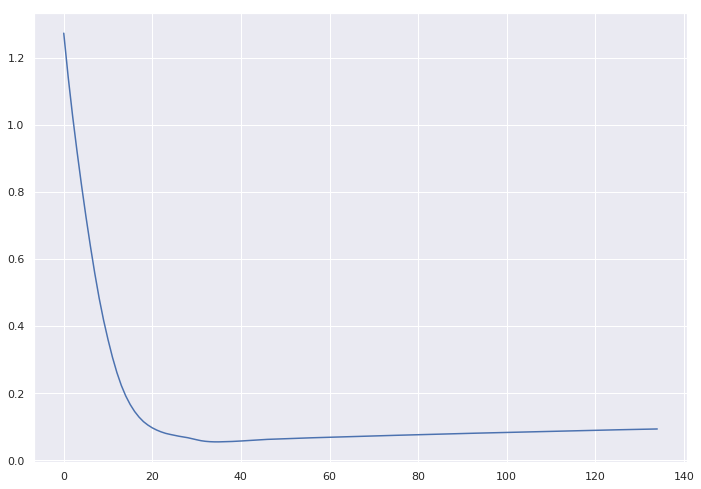

In [0]:
plt.plot(errors[15:])

# **Subpart - D**

### With batch Stochastic gradient descent


In [0]:
data["optimizer"] = "batch_sgd"

net, errors = train(data)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch =  0   _____  loss =  tensor(193.6258, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1   _____  loss =  tensor(13230.1631, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2   _____  loss =  tensor(750502.3750, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3   _____  loss =  tensor(336.0472, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4   _____  loss =  tensor(198.5260, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5   _____  loss =  tensor(134.5661, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6   _____  loss =  tensor(98.8012, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7   _____  loss =  tensor(76.5251, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8   _____  loss =  tensor(61.6125, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9   _____  loss =  tensor(51.0949, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10   _____  loss =  tensor(43.3766, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  11   _____ 

In [0]:
ops = predict(net, data, "train_data")

true positives =  733
true negatives =  6168
false positives =  996
false negatives =  246


In [0]:
ops = predict(net, data, "test_data")

true positives =  402
true negatives =  1663
false positives =  570
false negatives =  30


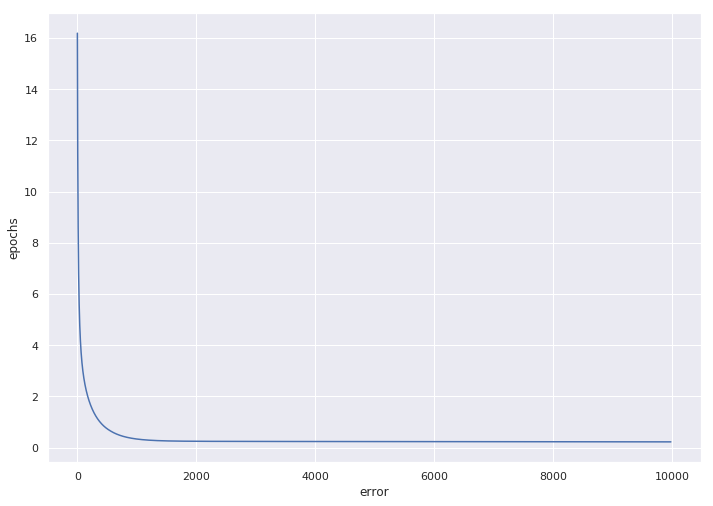

In [0]:
plt.xlabel("error")
plt.ylabel("epochs")
plt.plot(errors[20:])

### Stochastic gradient descent

In [0]:
data["device"] = device
data["criterion"] = "mse"
data["epochs"] = 1000
net, errors = train(data)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch =  0   _____  loss =  tensor(14669.0166, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1   _____  loss =  tensor(14664.6699, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2   _____  loss =  tensor(14660.3252, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3   _____  loss =  tensor(14655.9766, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4   _____  loss =  tensor(14651.6328, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5   _____  loss =  tensor(14647.2891, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6   _____  loss =  tensor(14642.9434, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7   _____  loss =  tensor(14638.6016, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8   _____  loss =  tensor(14634.2578, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9   _____  loss =  tensor(14629.9150, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10   _____  loss =  tensor(14625.5771, device='cuda:0', grad_fn=<MseLossBackward>

In [0]:
ops = predict(net, data, "train_data")

true positives =  1574
true negatives =  5801
false positives =  155
false negatives =  613


In [0]:
ops = predict(net, data, "test_data")

true positives =  972
true negatives =  1637
false positives =  0
false negatives =  56


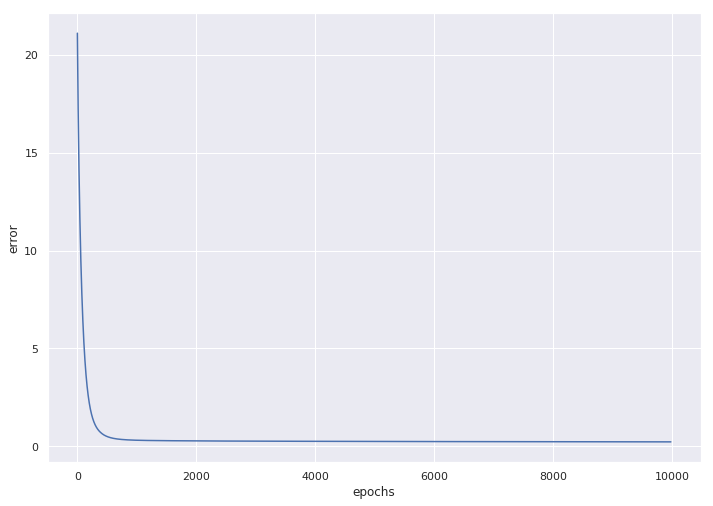

In [0]:
plt.ylabel("error")
plt.xlabel("epochs")
plt.plot(errors[20:])

### Observations
- Stochastic Gradient Descent has a sharp change in the reduction of error as can be observed from the error plots. 

- While the error plot in batch gradient descent is kind of smooth transition to convergence. 

- stochastic gradient descent gets impacted for each input that it observes while the batch gradient descent takes into consideration and averages out the gradients of all those inputs

# Subpart - E

In [0]:
def accuracy(outputs, real_outputs):
  
  correct = np.sum(1.0*(outputs == real_outputs))
  total = outputs.shape[0]
  accuracy = np.float(correct)/total
  
  return accuracy
  

In [0]:
def subpart_e(data):
  neurons = np.array([1,2,5,10,20])
  data["optimizer"] = "adam"
  data["print"] = "no"
  accuracies_train = []
  accuracies_test  = []
  
  for i in range(len(neurons)):
    print("neuron number = ", i)
    data["hidden_size"] = neurons[i]
    data["epochs"] = 1000
    net, errors = train(data)
    
    ops = predict(net, data, "test_data")
    accuracy_test = accuracy(ops, data["outputs_test"])
    accuracies_test.append(accuracy_test)    
    
    ops = predict(net, data, "train_data")
    accuracy_train = accuracy(ops, data["outputs"])
    accuracies_train.append(accuracy_train)    
  
  plt.title("test accuracies")
  plt.xlabel("neurons")
  plt.ylabel("test accuracies")
  plt.plot(neurons, accuracies_test)
  plt.figure()
  
  plt.title("train accuracies")
  plt.xlabel("neurons")
  plt.ylabel("train accuracies")
  plt.plot(neurons, accuracies_train)
  plt.figure()
    
    

## Plots Depicting percentage of correctly classified data  (3 - e)

neuron number =  0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  4


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


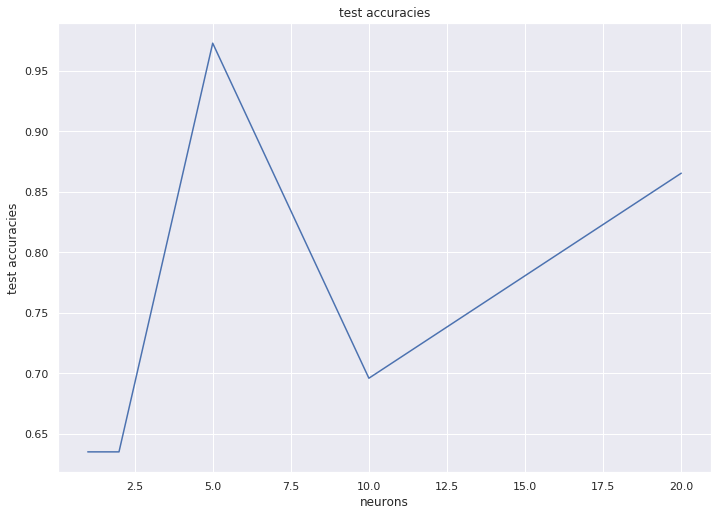

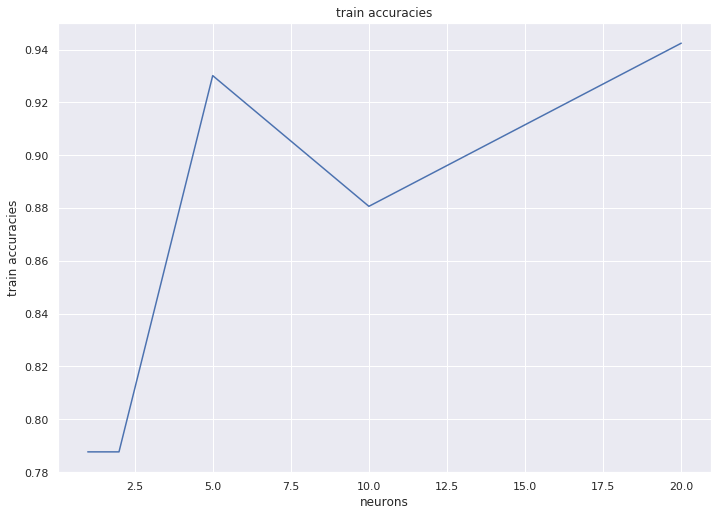

<Figure size 842.4x595.44 with 0 Axes>

In [0]:
data["criterion"] = "mse"
subpart_e(data)

# **Subpart - F**

neuron number =  0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  2


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  3


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


neuron number =  4


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


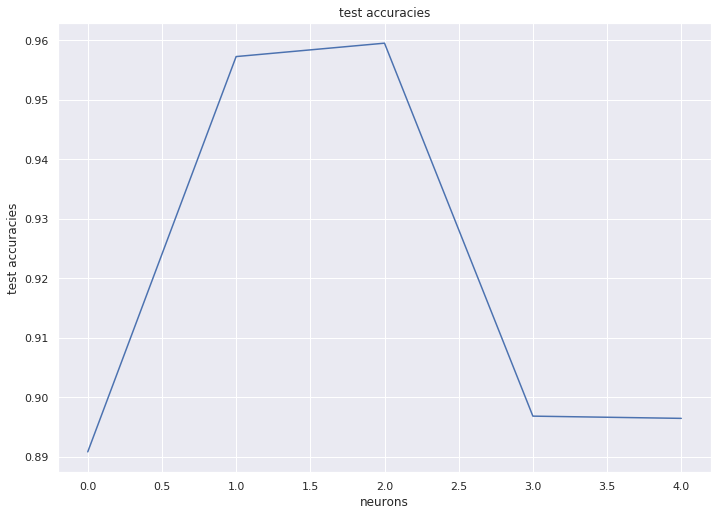

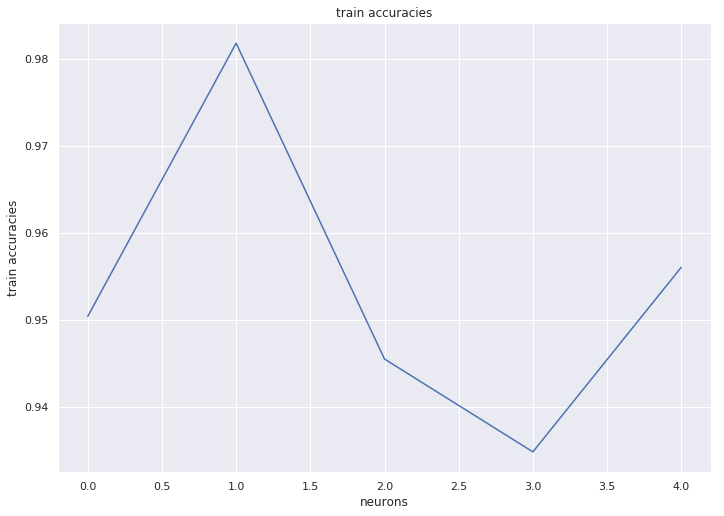

<Figure size 842.4x595.44 with 0 Axes>

In [0]:
data["criterion"] = "mse"
subpart_e(data)

## Differences between curves of MSE and Cross-Entropy

- Cross entropy error is generally used for classification, and here it is supposed to work well for binary classification. It assigns probability value for an output for belonging to one class or the other

- mean squared error function is supposed to converge faster than cross entropy loss

- While in Mean squared error, we get a raw output, which we need to threshold to classify into different classes. But, when the data is well clustered, there should not be a big differences in their performances

In [0]:
real_ops = data["outputs_test"]

# Subpart - G

In [16]:
data["device"] = device
data["criterion"] = "mse"
data["hidden"] = 15
data["optimizer"] = "adam"
data["hidden_second"] = 13
data["epochs"] = 1000
data["print"] = "yes"
net, errors = train(data)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8143])) that is different to the input size (torch.Size([8143, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch =  0   _____  loss =  tensor(16.2267, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  1   _____  loss =  tensor(16.1924, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  2   _____  loss =  tensor(16.1581, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  3   _____  loss =  tensor(16.1239, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  4   _____  loss =  tensor(16.0896, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  5   _____  loss =  tensor(16.0555, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  6   _____  loss =  tensor(16.0214, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  7   _____  loss =  tensor(15.9874, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  8   _____  loss =  tensor(15.9534, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  9   _____  loss =  tensor(15.9195, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  10   _____  loss =  tensor(15.8856, device='cuda:0', grad_fn=<MseLossBackward>)
epoch =  11   _____  loss =  te

### Neural net details


In [19]:
print(net)

Network(
  (hidden_first): Linear(in_features=5, out_features=20, bias=True)
  (relu): ReLU()
  (hidden_second): Linear(in_features=20, out_features=13, bias=True)
  (output): Linear(in_features=13, out_features=1, bias=True)
)


#### Observations

- I used Xavier initialization for initializing weights,  and a rather shallow network since this is just a binary classification. 

- The network structure is printed before this block 
- All the other criteria that I used for the network are below 


    data["device"] = device
    data["criterion"] = "mse"
    data["hidden"] = 15
    data["optimizer"] = "adam"
    data["hidden_second"] = 13
    data["epochs"] = 1000
    
    
- I think there would have been an increase in accuracy if I increase the depth a little 

In [17]:
ops = predict(net, data, "train_data")

true positives =  1391
true negatives =  5904
false positives =  338
false negatives =  510


In [18]:
ops = predict(net, data, "test_data")

true positives =  779
true negatives =  1628
false positives =  193
false negatives =  65
